# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL

/Users/skim0119/anaconda3/envs/ctf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Environment Setting

In [2]:
env = gym.make("cap-v0") # initialize the environment
policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)

UNKNOWN  = CONST.UNKNOWN # -1
TEAM1_BG = CONST.TEAM1_BACKGROUND # 0
TEAM2_BG = CONST.TEAM2_BACKGROUND # 1
TEAM1_AG = CONST.TEAM1_UGV # 2
TEAM2_AG = CONST.TEAM2_UGV # 4
TEAM1_FL = CONST.TEAM1_FLAG # 6
TEAM2_FL = CONST.TEAM2_FLAG # 7
OBSTACLE = CONST.OBSTACLE # 8
DEAD     = CONST.DEAD # 9
SELECTED = CONST.SELECTED # 10
COMPLETED= CONST.COMPLETED # 11

VISION_RANGE = CONST.UGV_RANGE
VISION_dX    = 2*VISION_RANGE+1
VISION_dY    = 2*VISION_RANGE+1

WARN: Environment '<class 'gym_cap.envs.cap_env.CapEnvGenerate'>' has deprecated methods. Compatibility code invoked.


## Discount Reward

In [3]:
gamma = 0.97

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    for t in reversed(range(r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def discount_rewards_multiagent(r, n_agents):
    discounted_r = np.reshape(r,(-1,n_agents)) # Reshape the r into vertical matrix with 'n_agents' columns
    for idx in range(n_agents):
        column = discounted_r[:,idx]                     # extract single column
        discounted_r[:,idx] = discount_rewards(column);  # Run discount_reward on the column, and substitute
    return np.reshape(discounted_r,(-1))                 # return the flattened matrix

## Network Setting

In [4]:
class agent():
    def __init__(self, lr, in_size,action_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
        conv1 = slim.conv2d(self.state_input, 64, [3,3],# activation_fn=tf.nn.relu,
                            scope='conv1')
        conv2 = slim.conv2d(conv1, 128, [2,2],# activation_fn=tf.nn.relu,
                            scope='conv2')
        flat  = tf.reshape(conv2, [-1, VISION_dX*VISION_dY*128])#slim.flatten(conv2)
        
        dense = slim.fully_connected(flat, action_size,
                                            #activation_fn=tf.nn.relu,
                                            biases_initializer=None)
        self.output = tf.nn.softmax(dense, name='action')
        #self.chosen_action = tf.argmax(self.output,1, name='action')

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.

        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder

        with tf.name_scope('loss'):
            self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)
            self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
            tf.summary.scalar('loss', self.loss)
            
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
    
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [5]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr=1e-4,in_size=[None,VISION_dX,VISION_dY,6],action_size=5) #Load the agent.
global_step = tf.Variable(0, trainable=False, name='global_step') # global step
increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

/Users/skim0119/anaconda3/envs/ctf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Hyperparameters

In [14]:
total_episodes = 100000 #Set total number of episodes to train agent on.
max_ep = 350
update_frequency = 5
save_frequency = 100

exploration_final = 0.01
exploration = 1.0
exploration_decay = 0.99

## Session

In [7]:
# Launch the session
sess = tf.Session()

total_reward = []
total_length = []

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

INFO:tensorflow:Restoring parameters from ./model/ctf_policy.ckpt-80913
Load Model :  ./model/ctf_policy.ckpt-80913


In [8]:
def one_hot_encoder(state, agents):
    ret = np.zeros((len(agents),VISION_dX,VISION_dY,6))
    # team 1 : (1), team 2 : (-1), map elements: (0)
    map_channel = {UNKNOWN:0, DEAD:0,
                   TEAM1_BG:1, TEAM2_BG:1,
                   TEAM1_AG:2, TEAM2_AG:2,
                   3:3, 5:3, # UAV, does not need to be included for now
                   TEAM1_FL:4, TEAM2_FL:4,
                   OBSTACLE:5}
    map_color   = {UNKNOWN:0, DEAD:0, OBSTACLE:0,
                   TEAM1_BG:1, TEAM2_BG:-1,
                   TEAM1_AG:1, TEAM2_AG:-1,
                   3:1, 5:-1, # UAV, does not need to be included for now
                   TEAM1_FL:1, TEAM2_FL:-1}
    
    # Expand the observation with 3-thickness wall
    # - in order to avoid dealing with the boundary
    sx, sy = state.shape
    _state = np.ones((sx+2*VISION_RANGE, sy+2*VISION_RANGE)) * OBSTACLE # 8 for obstacle
    _state[VISION_RANGE:VISION_RANGE+sx, VISION_RANGE:VISION_RANGE+sy] = state
    state = _state

    for idx,agent in enumerate(agents):
        # Initialize Variables
        x, y = agent.get_loc()
        x += VISION_RANGE
        y += VISION_RANGE
        vision = state[x-VISION_RANGE:x+VISION_RANGE+1,y-VISION_RANGE:y+VISION_RANGE+1] # extract the limited view for the agent (5x5)
        for i in range(len(vision)):
            for j in range(len(vision[0])):
                if vision[i][j] != -1:
                    channel = map_channel[vision[i][j]]
                    ret[idx][i][j][channel] = map_color[vision[i][j]]
    return ret

## Training

     0/100000 [.....] - ETA: 0s Average r :  42.18333333333333 0.99
save:  95817
   100/100000 [.....] - ETA: 20:17:51 Average r :  40.60133333333333 0.36237201786049694
save:  95917
   200/100000 [.....] - ETA: 20:52:59 Average r :  65.37133333333333 0.13263987810938213
save:  96017
   300/100000 [.....] - ETA: 21:54:28 Average r :  56.93916666666667 0.0485504851305729
save:  96117
   400/100000 [.....] - ETA: 22:41:56 Average r :  64.94083333333333 0.017771047742294682
save:  96217
   500/100000 [.....] - ETA: 22:42:31 Average r :  68.64016666666666 0.01
save:  96317
   600/100000 [.....] - ETA: 23:18:30 Average r :  51.32699999999999 0.01
save:  96417
   700/100000 [.....] - ETA: 22:59:39 Average r :  58.17616666666666 0.01
save:  96517
   800/100000 [.....] - ETA: 22:37:20 Average r :  53.43866666666668 0.01
save:  96617
   900/100000 [.....] - ETA: 22:11:47 Average r :  58.97866666666667 0.01
save:  96717
   999/100000 [.....] - ETA: 21:42:09 Average r :  59.058166666666665 0.01
s

  9300/100000 [.....] - ETA: 15:00:59 Average r :  37.507000000000005 0.01
save:  105117
  9400/100000 [.....] - ETA: 14:59:26 Average r :  35.218333333333334 0.01
save:  105217
  9500/100000 [.....] - ETA: 14:56:52 Average r :  45.45583333333333 0.01
save:  105317
  9600/100000 [.....] - ETA: 14:54:55 Average r :  49.3815 0.01
save:  105417
  9700/100000 [.....] - ETA: 14:53:07 Average r :  31.365 0.01
save:  105517
  9800/100000 [.....] - ETA: 14:51:23 Average r :  36.26233333333334 0.01
save:  105617
  9900/100000 [.....] - ETA: 14:48:56 Average r :  43.299499999999995 0.01
save:  105717
 10000/100000 [.....] - ETA: 14:47:46 Average r :  42.01700000000002 0.01
save:  105817
 10100/100000 [.....] - ETA: 14:46:17 Average r :  35.380833333333335 0.01
save:  105917
 10200/100000 [.....] - ETA: 14:45:17 Average r :  34.77366666666667 0.01
save:  106017
 10300/100000 [.....] - ETA: 14:43:49 Average r :  45.10100000000001 0.01
save:  106117
 10400/100000 [.....] - ETA: 14:40:51 Average r :

 18800/100000 [.....] - ETA: 13:09:11 Average r :  37.89833333333333 0.01
save:  114617
 18900/100000 [.....] - ETA: 13:08:24 Average r :  41.22033333333333 0.01
save:  114717
 19000/100000 [.....] - ETA: 13:07:37 Average r :  43.821000000000005 0.01
save:  114817
 19100/100000 [.....] - ETA: 13:05:40 Average r :  58.162666666666674 0.01
save:  114917
 19200/100000 [.....] - ETA: 13:03:37 Average r :  62.95266666666667 0.01
save:  115017
 19300/100000 [.....] - ETA: 13:02:5 - ETA: 13:02:54 Average r :  40.36166666666666 0.01
save:  115117
 19400/100000 [.....] - ETA: 13:01:33 Average r :  54.582166666666666 0.01
save:  115217
 19500/100000 [.....] - ETA: 13:00:33 Average r :  31.279166666666665 0.01
save:  115317
 19600/100000 [.....] - ETA: 12:59:01 Average r :  37.820166666666665 0.01
save:  115417
 19700/100000 [.....] - ETA: 12:57:32 Average r :  48.7895 0.01
save:  115517
 19800/100000 [.....] - ETA: 12:56:27 Average r :  44.022166666666664 0.01
save:  115617
 19900/100000 [.....]

 28200/100000 [>....] - ETA: 11:38:36 Average r :  49.353833333333334 0.01
save:  124017
 28300/100000 [>....] - ETA: 11:37:59 Average r :  63.961833333333345 0.01
save:  124117
 28400/100000 [>....] - ETA: 11:37:11 Average r :  40.12833333333333 0.01
save:  124217
 28500/100000 [>....] - ETA: 11:36:35 Average r :  47.18516666666667 0.01
save:  124317
 28600/100000 [>....] - ETA: 11:35:57 Average r :  43.462333333333326 0.01
save:  124417
 28700/100000 [>....] - ETA: 11:35:22 Average r :  49.05283333333334 0.01
save:  124517
 28800/100000 [>....] - ETA: 11:34:19 Average r :  49.39883333333332 0.01
save:  124617
 28900/100000 [>....] - ETA: 11:33:54 Average r :  42.455666666666666 0.01
save:  124717
 28999/100000 [>....] - ETA: 11:33:10 Average r :  40.42016666666667 0.01
save:  124817
 29100/100000 [>....] - ETA: 11:32:04 Average r :  55.10316666666667 0.01
save:  124917
 29199/100000 [>....] - ETA: 11:31:01 Average r :  62.05766666666666 0.01
save:  125017
 29300/100000 [>....] - ETA:

 37600/100000 [>....] - ETA: 10:03:02 Average r :  47.39683333333333 0.01
save:  133417
 37700/100000 [>....] - ETA: 10:02:02 Average r :  44.869499999999995 0.01
save:  133517
 37800/100000 [>....] - ETA: 10:00:59 Average r :  53.999 0.01
save:  133617
 37900/100000 [>....] - ETA: 9:59:44 Average r :  47.12866666666667 0.01
save:  133717
 38000/100000 [>....] - ETA: 9:58:57 Average r :  35.34233333333333 0.01
save:  133817
 38100/100000 [>....] - ETA: 9:57:53 Average r :  57.60916666666666 0.01
save:  133917
 38200/100000 [>....] - ETA: 9:56:47 Average r :  42.54750000000001 0.01
save:  134017
 38300/100000 [>....] - ETA: 9:55:31 Average r :  49.839166666666664 0.01
save:  134117
 38400/100000 [>....] - ETA: 9:54:32 Average r :  40.63249999999999 0.01
save:  134217
 38500/100000 [>....] - ETA: 9:53:38 Average r :  37.9855 0.01
save:  134317
 38600/100000 [>....] - ETA: 9:52:38 Average r :  44.201 0.01
save:  134417
 38700/100000 [>....] - ETA: 9:51:35 Average r :  46.71566666666668 0.

 47200/100000 [=>...] - ETA: 8:25:11 Average r :  50.43016666666667 0.01
save:  143017
 47300/100000 [=>...] - ETA: 8:24:04 Average r :  48.55550000000001 0.01
save:  143117
 47400/100000 [=>...] - ETA: 8:23:10 Average r :  49.24049999999999 0.01
save:  143217
 47500/100000 [=>...] - ETA: 8:22:17 Average r :  50.13849999999999 0.01
save:  143317
 47600/100000 [=>...] - ETA: 8:21:37 Average r :  44.6365 0.01
save:  143417
 47700/100000 [=>...] - ETA: 8:20:45 Average r :  45.707 0.01
save:  143517
 47800/100000 [=>...] - ETA: 8:19:57 Average r :  63.20099999999999 0.01
save:  143617
 47900/100000 [=>...] - ETA: 8:18:47 Average r :  64.62233333333332 0.01
save:  143717
 48000/100000 [=>...] - ETA: 8:17:46 Average r :  45.131833333333326 0.01
save:  143817
 48100/100000 [=>...] - ETA: 8:16:48 Average r :  48.596000000000004 0.01
save:  143917
 48200/100000 [=>...] - ETA: 8:15:47 Average r :  43.64883333333332 0.01
save:  144017
 48300/100000 [=>...] - ETA: 8:14:47 Average r :  34.799333333

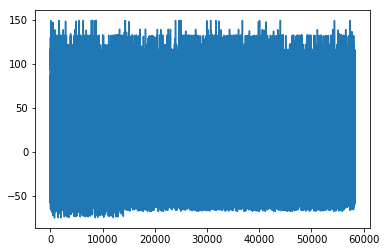

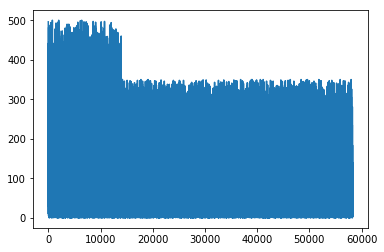

In [15]:
ep = 0

action_space = 5
n_agent = len(env.get_team_blue)

gradBuffer = sess.run(tf.trainable_variables())
for ix,grad in enumerate(gradBuffer):
    gradBuffer[ix] = grad * 0
try:
    progbar = tf.keras.utils.Progbar(total_episodes,width=5)
    while ep < total_episodes:
        progbar.update(ep) # update progress bar
        s = env.reset(map_size=20, policy_red=policy_red) #, render_mode='env')
        prev_reward=0
        running_reward = 0
        ep_history = []
        
        prev_loc = [ag.get_loc() for ag in env.get_team_blue]
        for j in range(max_ep+1):
            obs = one_hot_encoder(s, env.get_team_blue).tolist() # observation
            if exploration > np.random.random(): # explorate
                a = np.random.randint(action_space, size=len(env.get_team_blue)).tolist()
            else:
                obs = one_hot_encoder(s, env.get_team_blue).tolist()
                a = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
                #Probabilistically pick an action given our network outputs.
                a = [np.random.choice(action_space, p=a[x]/sum(a[x])) for x in range(n_agent)] # divide by sum : normalize
            s1,r_a,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            
            # post-evaluate reward
            # 1. If the action was not 0(stay) but the agent did not move, give negative point.
            r_p = [0 for _ in range(len(env.get_team_blue))]
            for idx, agent in enumerate(env.get_team_blue):
                loc = agent.get_loc()
                if a[idx] != 0 and prev_loc[idx] == loc:
                    r_p.append(-1)
                else:
                    r_p.append(0)
            prev_loc = [ag.get_loc() for ag in env.get_team_blue]
            
            # Rendering
            #env.render(mode="fast")
            #time.sleep(0.05)

            r = r_a-prev_reward # immediate reward
            prev_reward = r_a
            if j == max_ep: r = -10 # negative reward for stall-state

            #for state, act in zip(obs, a):
            for i in range(len(env.get_team_blue)):
                ep_history.append([obs[i],a[i],r+r_p[i],s1])
            # ep_history.append(s,r,a,s1)
            s = s1
            running_reward += r
            if d == True: # or r > 0:
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards_multiagent(ep_history[:,2], len(env.get_team_blue))
                #ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                           myAgent.action_holder:ep_history[:,1],
                           myAgent.state_input:np.stack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if ep % update_frequency == 0 and ep != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0

                total_reward.append(running_reward)
                total_length.append(j)
                break

        exploration = max(exploration_decay*exploration, exploration_final)
            #Update our running tally of scores.
        if ep % save_frequency == 0:
            print(' Average r : ', np.mean(total_reward[-100:]), exploration)
            saver.save(sess, './model/ctf_policy.ckpt', global_step=global_step)
            print("save: ", sess.run(global_step))

        ep += 1
        sess.run(increment_global_step_op)
except KeyboardInterrupt:
    print('\n\nManually stopped the training (KeyboardInterrupt)');
    plt.plot(total_reward)
    plt.figure()
    plt.plot(total_length)
    saver.save(sess, './model/ctf_policy.ckpt', global_step=global_step)
    print("save: ", sess.run(global_step), 'episodes')

In [16]:
obs = one_hot_encoder(s, env.get_team_blue)
print(sess.run(myAgent.output, feed_dict={myAgent.state_input:obs}))

[[0.15944351 0.15944351 0.25864774 0.2630218  0.15944351]
 [0.1356498  0.1356498  0.35410002 0.23895061 0.1356498 ]
 [0.15647826 0.15647826 0.15647826 0.37408692 0.15647826]
 [0.18855068 0.18855068 0.2457973  0.18855068 0.18855068]
 [0.14657007 0.14657007 0.4137197  0.14657007 0.14657007]]


In [17]:
obs = one_hot_encoder(s, env.get_team_blue)
for i in range(len(env.get_team_blue)):
    sub_obs = np.stack([obs[i,:,:,:]])
    print(sess.run(myAgent.output, feed_dict={myAgent.state_input:sub_obs}))

[[0.15944348 0.15944348 0.25864786 0.2630217  0.15944348]]
[[0.13564973 0.13564973 0.35410032 0.23895048 0.13564973]]
[[0.15647826 0.15647826 0.15647826 0.37408692 0.15647826]]
[[0.18855065 0.18855065 0.24579749 0.18855065 0.18855065]]
[[0.14657012 0.14657012 0.4137196  0.14657012 0.14657012]]
